In [1]:
import pickle
import gzip
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
np.random.seed(666)

In [2]:
filename = '../mnist.pkl.gz'
f = gzip.open(filename, 'rb')
training_data, validation_data, test_data = pickle.load(f, encoding='latin1')
f.close()

In [87]:
# Functions
def one_hot_vect(tuple_data,classes):
    one_hot_encoded=np.zeros((len(tuple_data[1]),len(classes)))
    identity = np.identity(len(classes))
    for i in range(len(tuple_data[1])):
        one_hot_encoded[i] = np.add(one_hot_encoded[i],identity[tuple_data[1][i]])
    return one_hot_encoded

def softmax(weights,train_data):
    bias = np.ones((np.shape(train_data)[0],1))
    train_withBias = np.hstack((train_data,bias))
    num = np.dot(weights,train_withBias.T)
    # High value Fix
    # https://houxianxu.github.io/2015/04/23/logistic-softmax-regression/
    num = np.subtract(num,np.max(num,axis=0))
    num = np.exp(num)
    # Fix softmax when using batch size 1 the dimension of deno changes
    if(len(train_data) == 1):
        deno = np.sum(num,axis=0)
    else:
        deno = np.sum(num,axis=1)
        deno = deno.reshape((10,1))
    return np.divide(num,deno)

def cross_entropy_error(predicted,target):
    right = np.log(predicted)
    loss = np.multiply(np.matrix(target),np.transpose(np.matrix(right)))
    return -np.sum(np.sum(loss,axis=1),axis=0)

def batch_gradient(predicted,train_data,target):
    leftleft = np.transpose(predicted)
    left = np.subtract(leftleft,target)
    bias = np.ones((np.shape(train_data)[0],1))
    train_withBias = np.hstack((train_data,bias))
    gradient = np.dot(left.T,train_withBias)
    gradient = gradient/len(train_data)
    return np.matrix(gradient,dtype="float64")

def accuracy(predicted,target):
    correct = 0
    left = np.array(np.argmax(predicted,axis=0)).flatten()
    right = np.argmax(target,axis=1)
    confusion_mat = np.zeros((len(np.unique(right)),len(np.unique(left))))
    for i in range(len(target)):
        if(left[i] == right[i]):
            correct+=1
        confusion_mat[left[i]][right[i]] =confusion_mat[left[i]][right[i]] +1
    return correct/len(target),pd.DataFrame(np.matrix(confusion_mat,dtype="int32"))

def more_metrics(conf_mat):
    true_positives = 0
    precision = []
    recall = []
    for i in range(len(conf_mat)):
        true_positives += conf_mat.iloc[i,i]
    conf_mat = np.matrix(conf_mat)
    tp_fp = np.array(np.sum(conf_mat,axis=1)).ravel()
    relevant_elements = np.array(np.sum(conf_mat,axis=0)).ravel()
    for i in range(len(conf_mat)):
        precision.append(conf_mat[i,i]/tp_fp[i])
        recall.append(conf_mat[i,i]/relevant_elements[i])
    return true_positives,precision,recall

In [241]:
# Fixed Var
classes = np.unique(training_data[1])
weights = np.random.randn(len(classes), np.shape(training_data[0])[1]+1) * 0.001
train_data = training_data[0]

In [331]:
target = one_hot_vect(training_data,classes)
target_val = one_hot_vect(validation_data,classes)
target_test = one_hot_vect(test_data,classes)
scaler = StandardScaler()
scaler.fit(train_data)
scaler.fit(validation_data[0])
scaler.fit(test_data[0])
processed_train_data = scaler.transform(train_data)
processed_val_data = scaler.transform(validation_data[0])
processed_test_data = scaler.transform(test_data[0])
predicted = softmax(weights,processed_train_data)

In [337]:
batchSize = 400
batches = len(processed_train_data)/batchSize
start = 0
end = batchSize
weights = np.random.randn(len(classes), np.shape(training_data[0])[1]+1) * 0.001
predicted = softmax(weights,processed_train_data[start:end,:])
i = 1
training_loss =[]
val_loss=[]
logging=False
while(i<batches):
    print("Percentage Done: "+str(i/batches))
    new_weights = batch_gradient(predicted,processed_train_data[start:end,:],target[start:end,:])
    weights = weights - 0.0003*new_weights
    if(logging):
        # Predict Train & Validation for these weights
        predict_val = softmax(weights,processed_val_data)
        # Calculate cost of predicting Validation and Training, To see if the hyper param are working
        cost = np.asscalar(cross_entropy_error(predict_val,target_val))
        val_loss.append(cost)
        predict_train = softmax(weights,processed_train_data)
        cost = np.asscalar(cross_entropy_error(predict_train,target))
        training_loss.append(cost)
    #print("Training Loss: "+str(cost/len(processed_train_data)))
    start = start + batchSize
    end = end + batchSize
    # New Prediction for the data
    predicted = softmax(weights,processed_train_data[start:end,:])
    if(not logging):
        cost = np.asscalar(cross_entropy_error(predicted,target[start:end,:]))
        print("Cost of Batch: "+str(cost))
    i = i+1
    

Percentage Done: 0.008
Cost of Batch: 2397.6438315588707
Percentage Done: 0.016
Cost of Batch: 2397.3187850053546
Percentage Done: 0.024
Cost of Batch: 2398.8101702275435
Percentage Done: 0.032
Cost of Batch: 2397.549717617505
Percentage Done: 0.04
Cost of Batch: 2397.0436490206325
Percentage Done: 0.048
Cost of Batch: 2410.53394900608
Percentage Done: 0.056
Cost of Batch: 2396.8114533839416
Percentage Done: 0.064
Cost of Batch: 2396.3552219993217
Percentage Done: 0.072
Cost of Batch: 2397.382270100928
Percentage Done: 0.08
Cost of Batch: 2396.9988059300467
Percentage Done: 0.088
Cost of Batch: 2396.6145389406943
Percentage Done: 0.096
Cost of Batch: 2410.278060110275
Percentage Done: 0.104
Cost of Batch: 2396.3167591449624
Percentage Done: 0.112
Cost of Batch: 2397.5591447325564
Percentage Done: 0.12
Cost of Batch: 2397.4505628079883
Percentage Done: 0.128
Cost of Batch: 2396.8208444792517
Percentage Done: 0.136
Cost of Batch: 2396.7175200532492
Percentage Done: 0.144
Cost of Batch: 2

In [332]:
np.random.shuffle(processed_train_data)

In [338]:
df = pd.DataFrame(training_loss)
ax = df.plot(figsize=(10,15))
ax.ticklabel_format(useOffset=False)
plt.savefig('./train_loss.png',bbox_inches='tight')
plt.show(ax)

TypeError: Empty 'DataFrame': no numeric data to plot

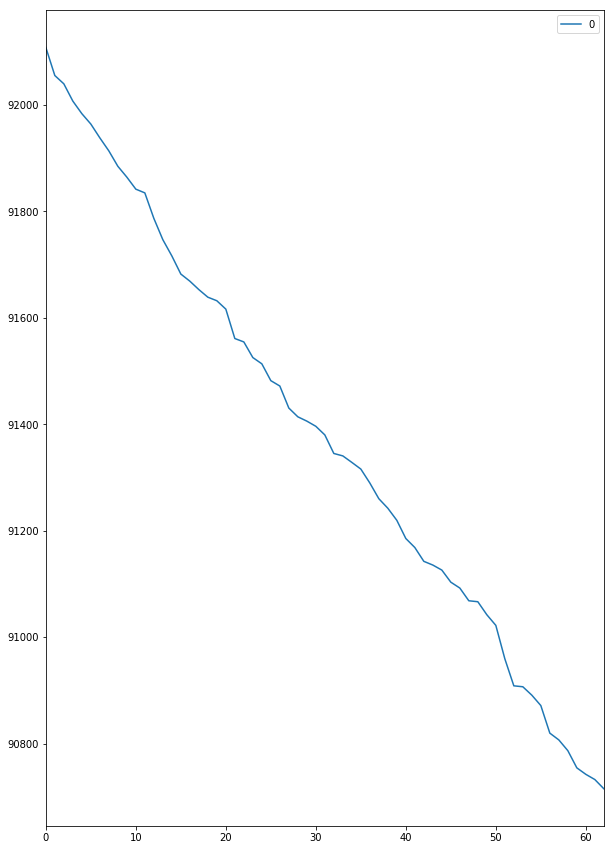

In [300]:
df = pd.DataFrame(val_loss)
ax = df.plot(figsize=(10,15))
ax.ticklabel_format(useOffset=False)
plt.savefig('./val_loss.png',bbox_inches='tight')
plt.show(ax)

In [339]:
predict_val = softmax(weights,processed_val_data)
accuracy(predict_val,one_hot_vect(validation_data,classes))

(0.1511,      0    1    2    3    4    5    6    7    8    9
 0   42   16   82  121   50   99   42  175  194  110
 1  268   12   46  218   57  164   64   85   74   40
 2   31  230   30  196   31  185   40   47  110   78
 3  120    4   71  149   73   66   66  111   50  150
 4  320  338  109   38  174   85  178   12  143   14
 5  102    3   89   86   48  184   92   22   67   43
 6   28    7  247   15  169   39  350   79  186  212
 7   65   82  159   19   14   19   53  397   32   95
 8    1   32   68  134  119   24   58   44   59  105
 9   14  340   89   54  248   50   24  118   94  114)

In [340]:
predict_test = softmax(weights,processed_test_data)
accuracy(predict_test,target_test)

(0.1322,      0    1    2    3    4    5    6    7    8    9
 0   28   21   86  162   63  109   25  157  140  101
 1  238    9   59  253   45  182   70   81   84   46
 2   25  299   33  167   38  159   27   56   96   78
 3  109    0   87  154  100   47   77  100   51  173
 4  354  300  135   26  104   97  189   22  119   13
 5   96    2   99   96   27  163  125   17   96   34
 6   30    8  241   20  172   32  285   88  213  243
 7   81   87  128   26   19   35   61  356   25   83
 8    8   29   82   83  158   28   72   48   57  105
 9   11  380   82   23  256   40   27  103   93  133)

In [264]:
true_positives,precision,recall = more_metrics(conf_mat)

In [304]:
acc

0.597